In [78]:
import numpy as np
import matplotlib.pyplot as plt
from backtester.backtester import Backtester
from backtester.strategy import Strategy
from backtester.historical_data import HistoricalData
import talib as ta

In [91]:
asset = "BTC-USD"
long_start = '2024-05-21'
long_end = '2024-08-22'
long_interval = '1H'
short_start = '2024-06-26'
short_end = '2024-08-22'
short_interval = '15m'

In [100]:
short_period = 50
trend_period = 100
atr_period = 14
trend_ema_offset = 0.999
stop_loss_ratio = 0.1
commission_percentage = 0.001
amount_invested = 1000
leverage = 1

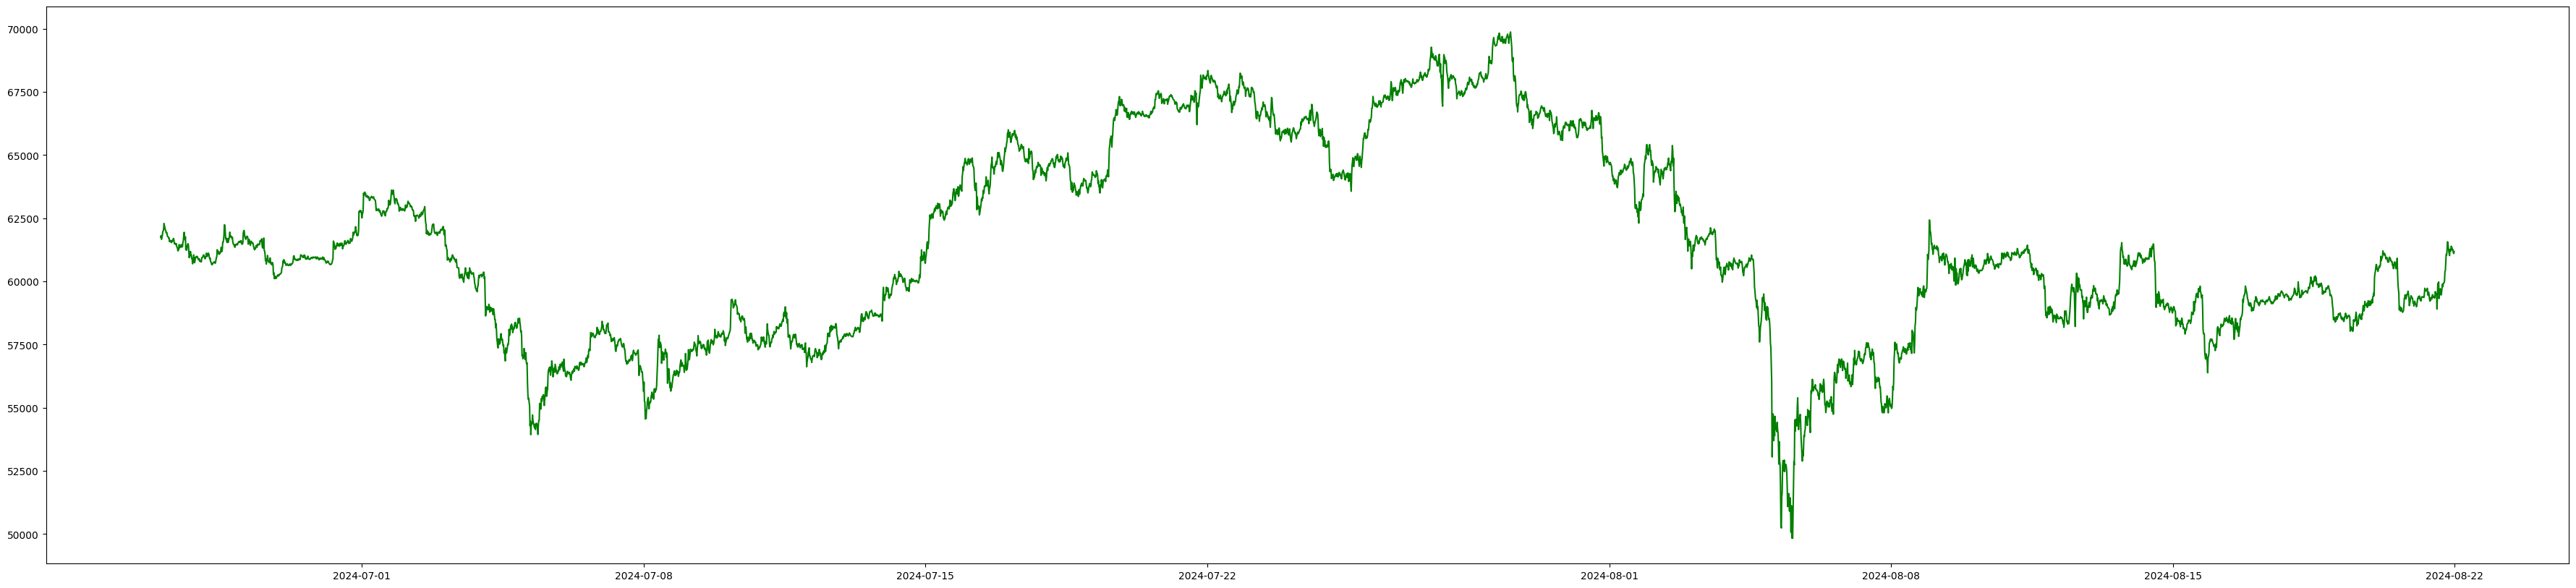

In [101]:
short_historical_data = HistoricalData(asset, short_start, short_end, short_interval)
short_data = short_historical_data.get_data()
short_historical_data.plot_data()

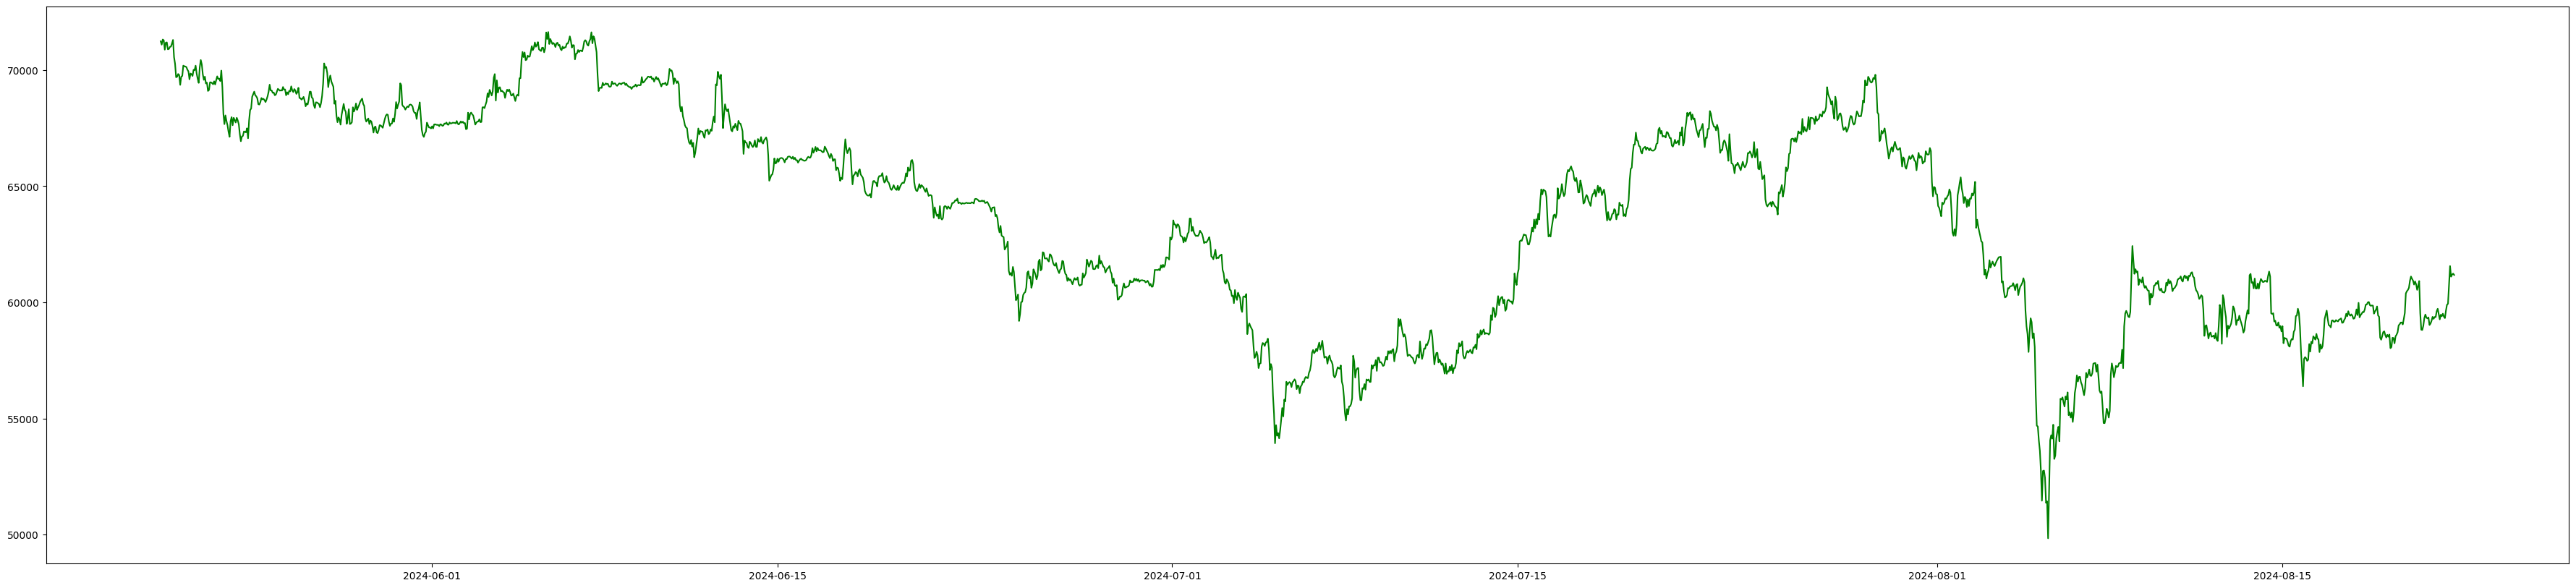

In [102]:
long_historical_data = HistoricalData(asset, long_start, long_end, long_interval)
long_data = long_historical_data.get_data()
long_historical_data.plot_data()

In [103]:
from datetime import timedelta


class TrendFollowingEMACrossoverShortStrategy(Strategy):
    def __init__(self, data, long_data):
        super().__init__(data)
        self.long_data = long_data
        self.long_data['Daily EMA'] = ta.EMA(self.long_data['Close'], trend_period) * trend_ema_offset
        self.data['EMA'] = ta.EMA(self.data['Close'], short_period)
        self.data['Previous EMA'] = self.data['EMA'].shift()
        self.data['Hourly Date'] = self.data.index.floor('h')
        self.data['ATR'] = ta.ATR(self.data['High'], self.data['Low'], self.data['Close'], timeperiod=atr_period)
             
    def implement(self):
        self.data['Signal'] = 0
        self.position = 'close'

        for i in self.data.index:
            if self.position == 'close':
                if (self.data.at[i, 'EMA'] < long_data.at[self.data.at[i, 'Hourly Date'], 'Daily EMA']):
                    sell_price = self.data['Close'][i]
                    stop_loss = sell_price + (2 * self.data.at[i, 'ATR'])
                    take_profit = sell_price - (8 * self.data.at[i, 'ATR'])
                    self.position = 'sell'
                    self.sell_trade(i, stop_loss=stop_loss, take_profit=take_profit)
                    self.data.at[i, 'Signal'] = -1
            else:            
                if (self.data.at[i, 'EMA'] > self.long_data.at[self.data.at[i, 'Hourly Date'], 'Daily EMA']) \
                    | (self.data.at[i, 'Close'] >= self.stop_loss) | (self.data.at[i, 'Close'] <= self.take_profit):
                    self.close_trade(i)
                    self.data.at[i, 'Signal'] = 0
                    self.position = 'close'
                else:
                    self.data.at[i, 'Signal'] = -1

    def plot_indicators(self):
        _, axis = plt.subplots(2, sharex=True, figsize=(45, 25))
        axis[0].plot(self.long_data.index, self.long_data.Close, color='green')
        axis[0].plot(self.data.index, self.data.Close, color='blue')
        axis[0].plot(self.long_data.index, self.long_data['Daily EMA'], color='black')
        axis[0].plot(self.data.index, self.data['EMA'], color='red')

        axis[1].plot(self.data.index, self.data['ATR'], color='red')
        plt.show()

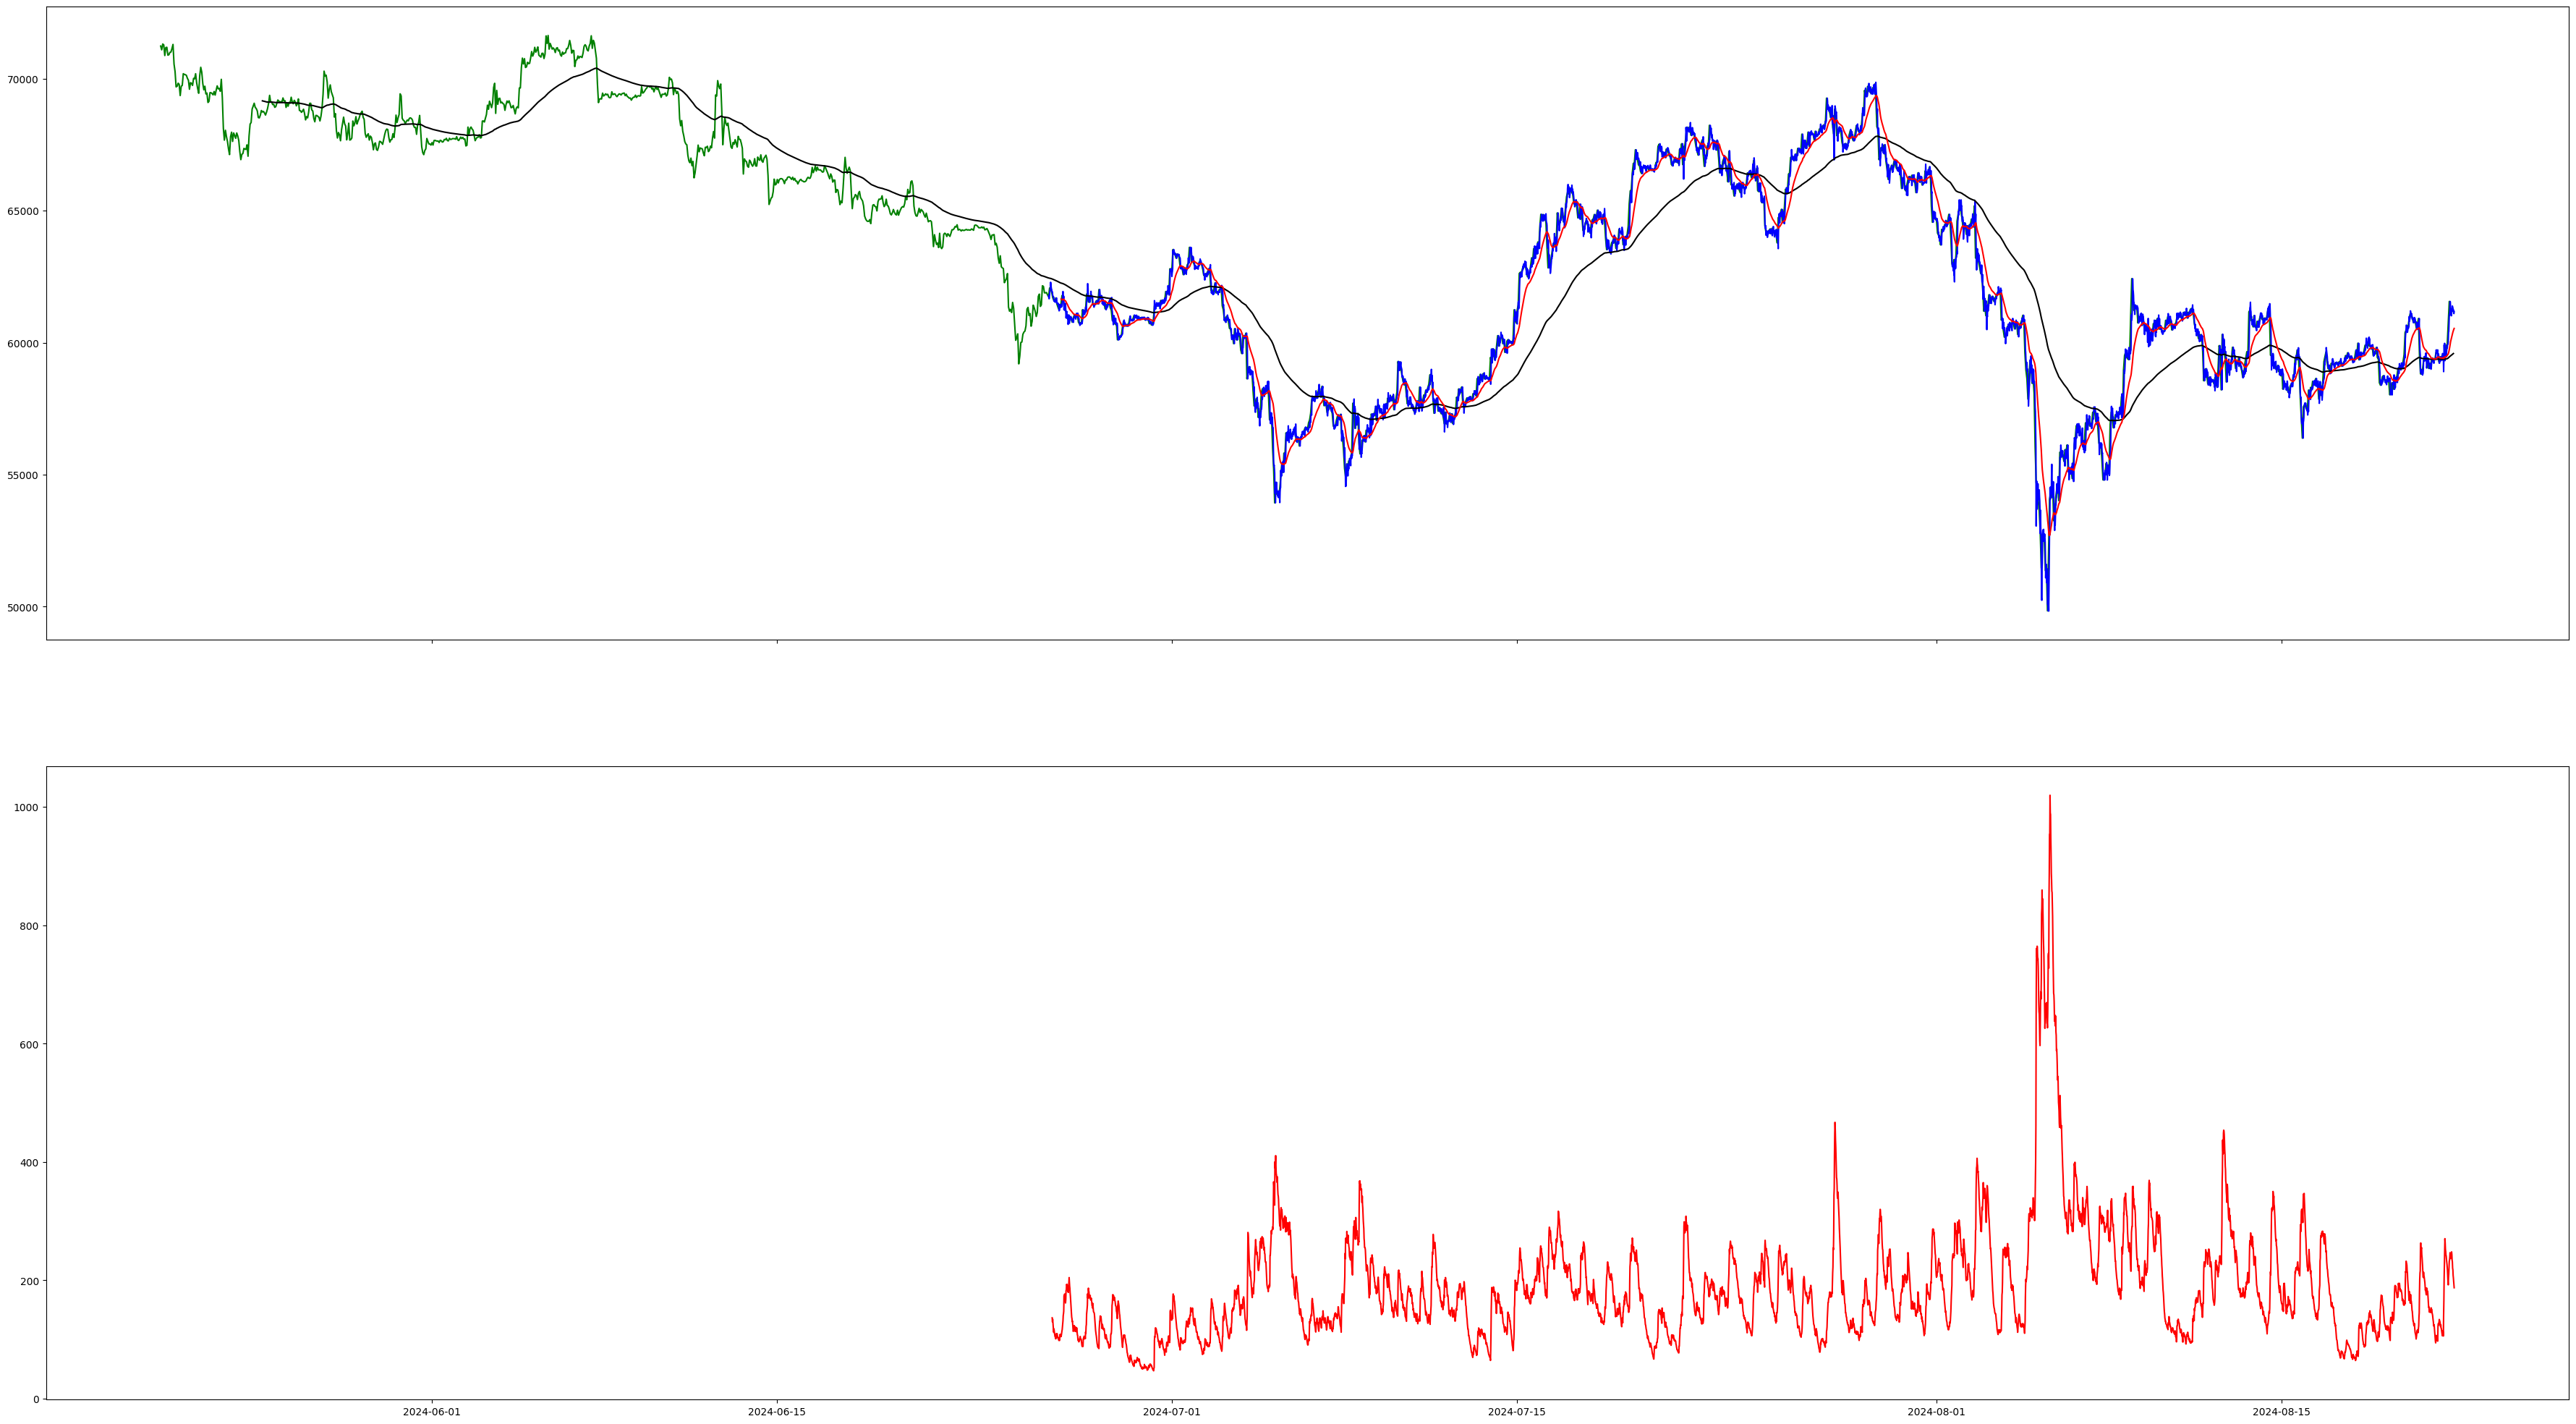

In [104]:
emaStrategy = TrendFollowingEMACrossoverShortStrategy(data=short_data, long_data=long_data)
emaStrategy.plot_indicators()

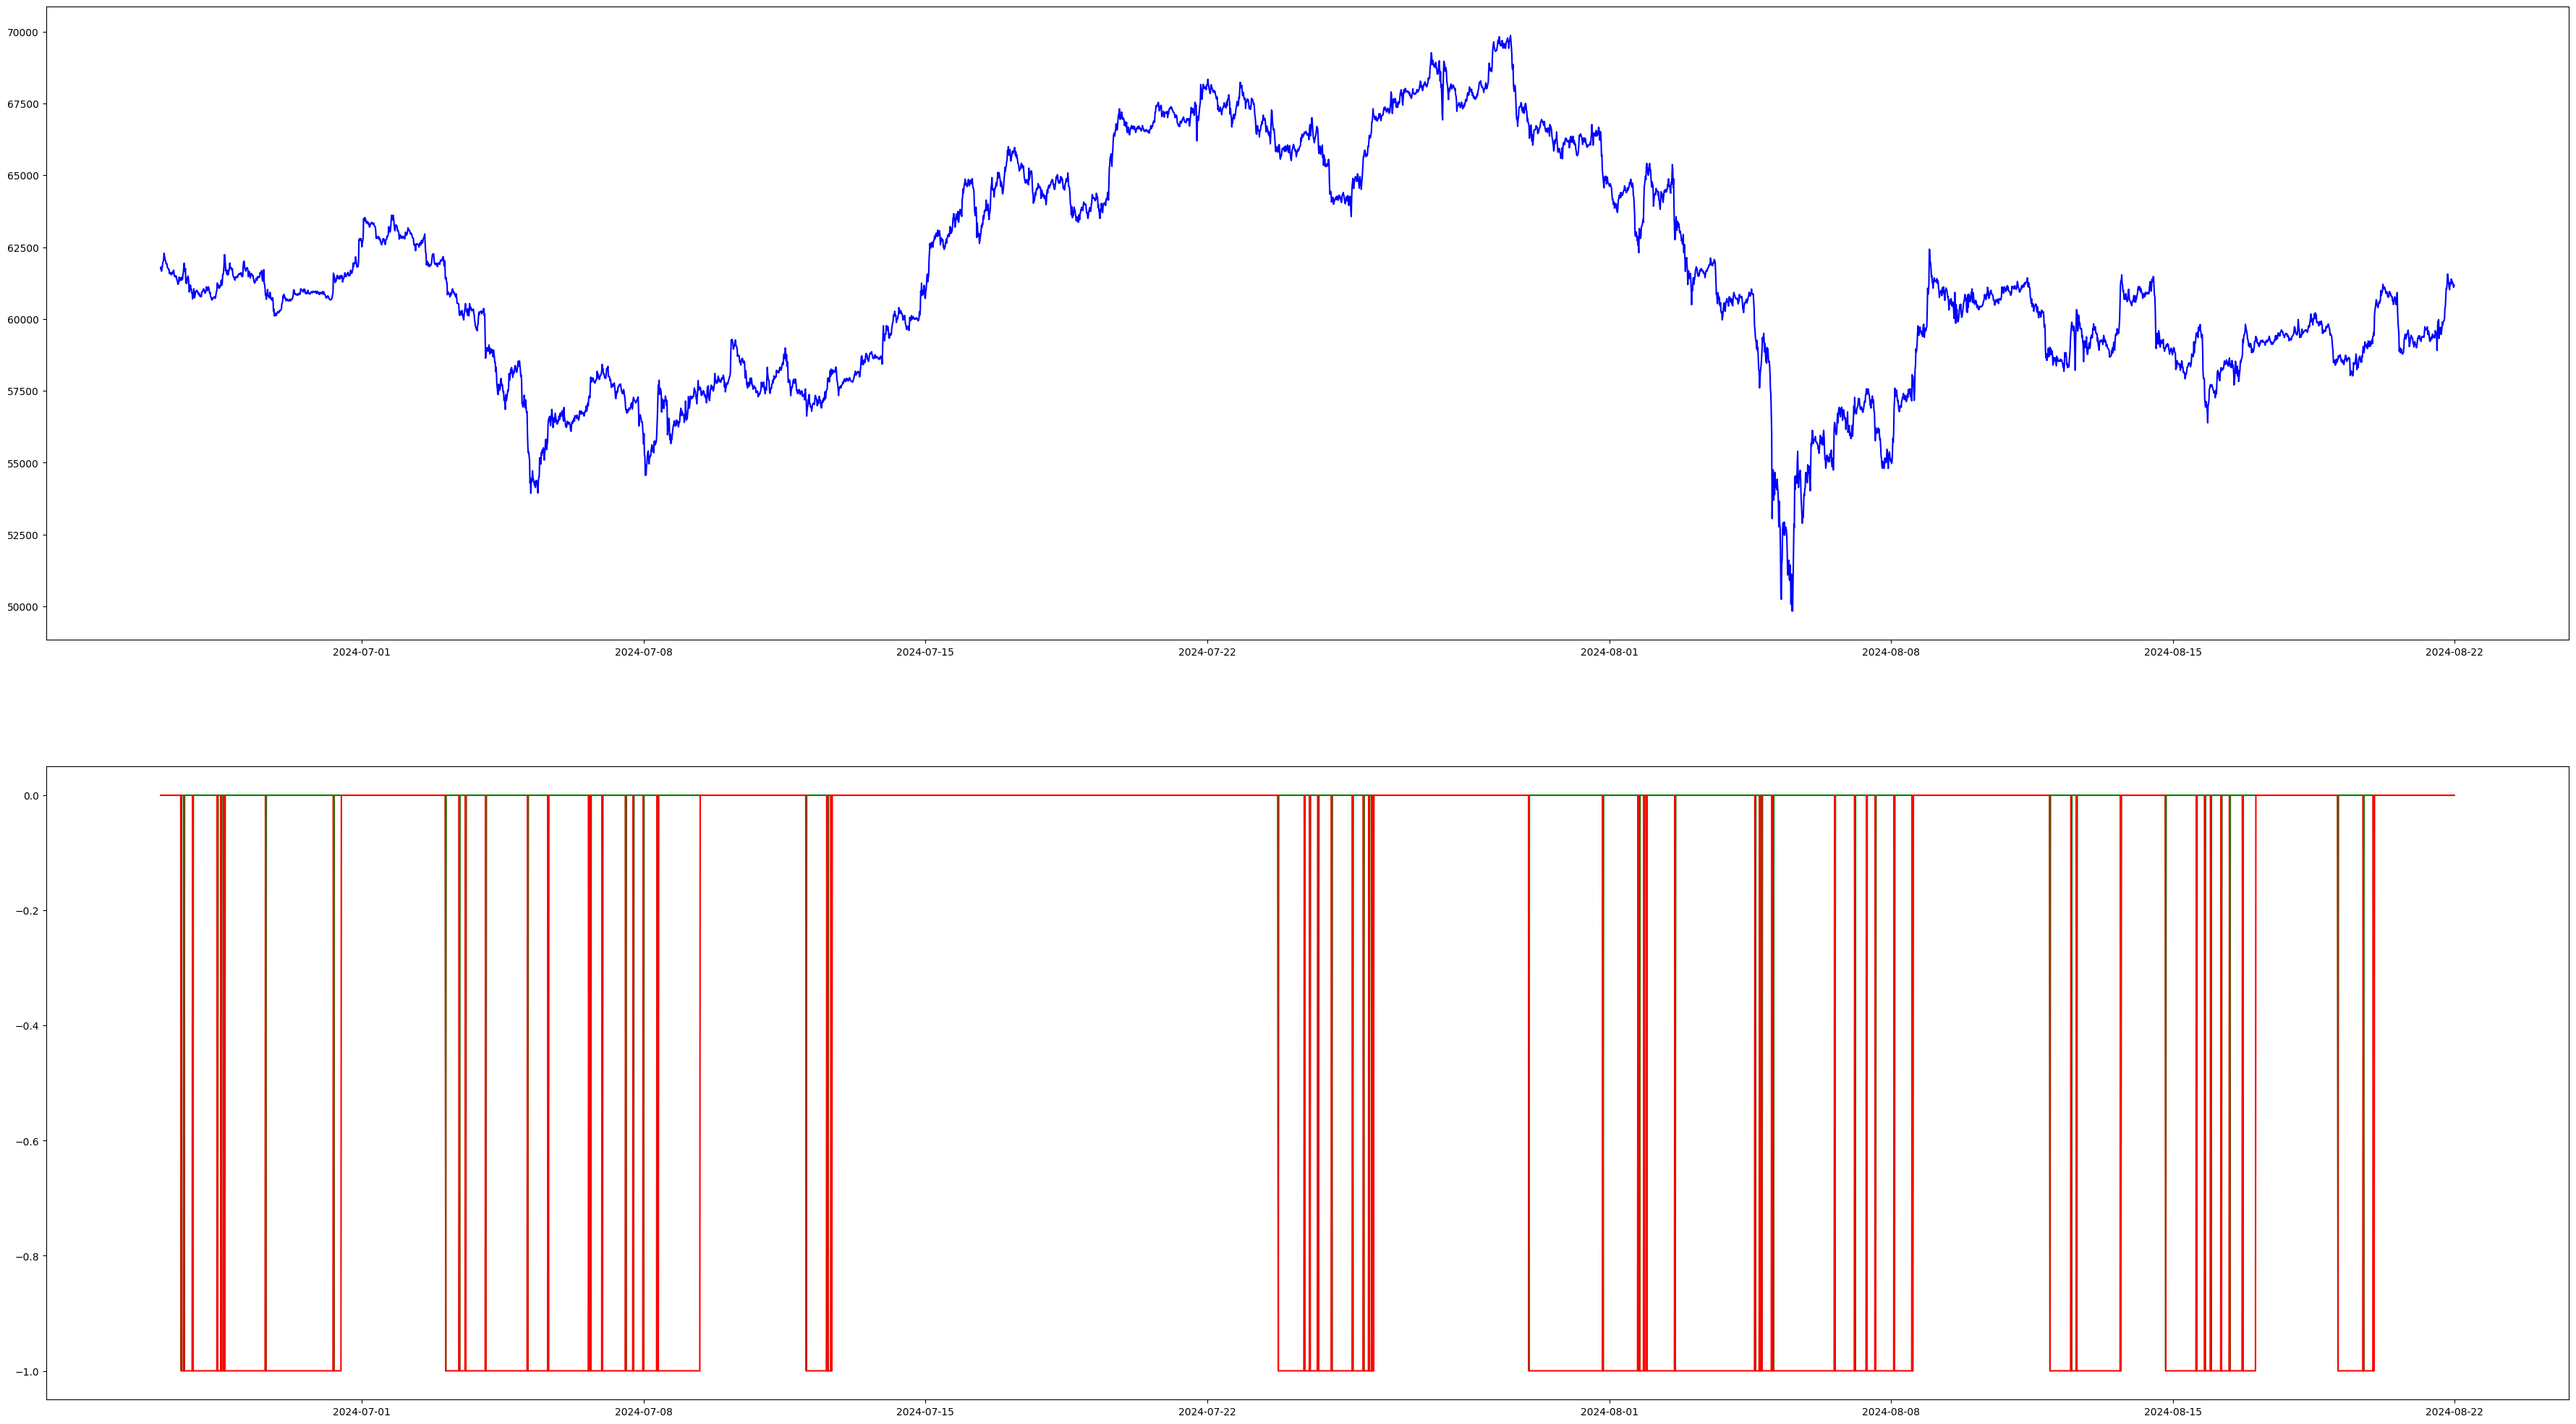

In [105]:
emaStrategy.implement()
emaStrategy.plot_positions()

/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1000.484138885802' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.data.at[i, 'Cumulative Strategy Returns'] = cash


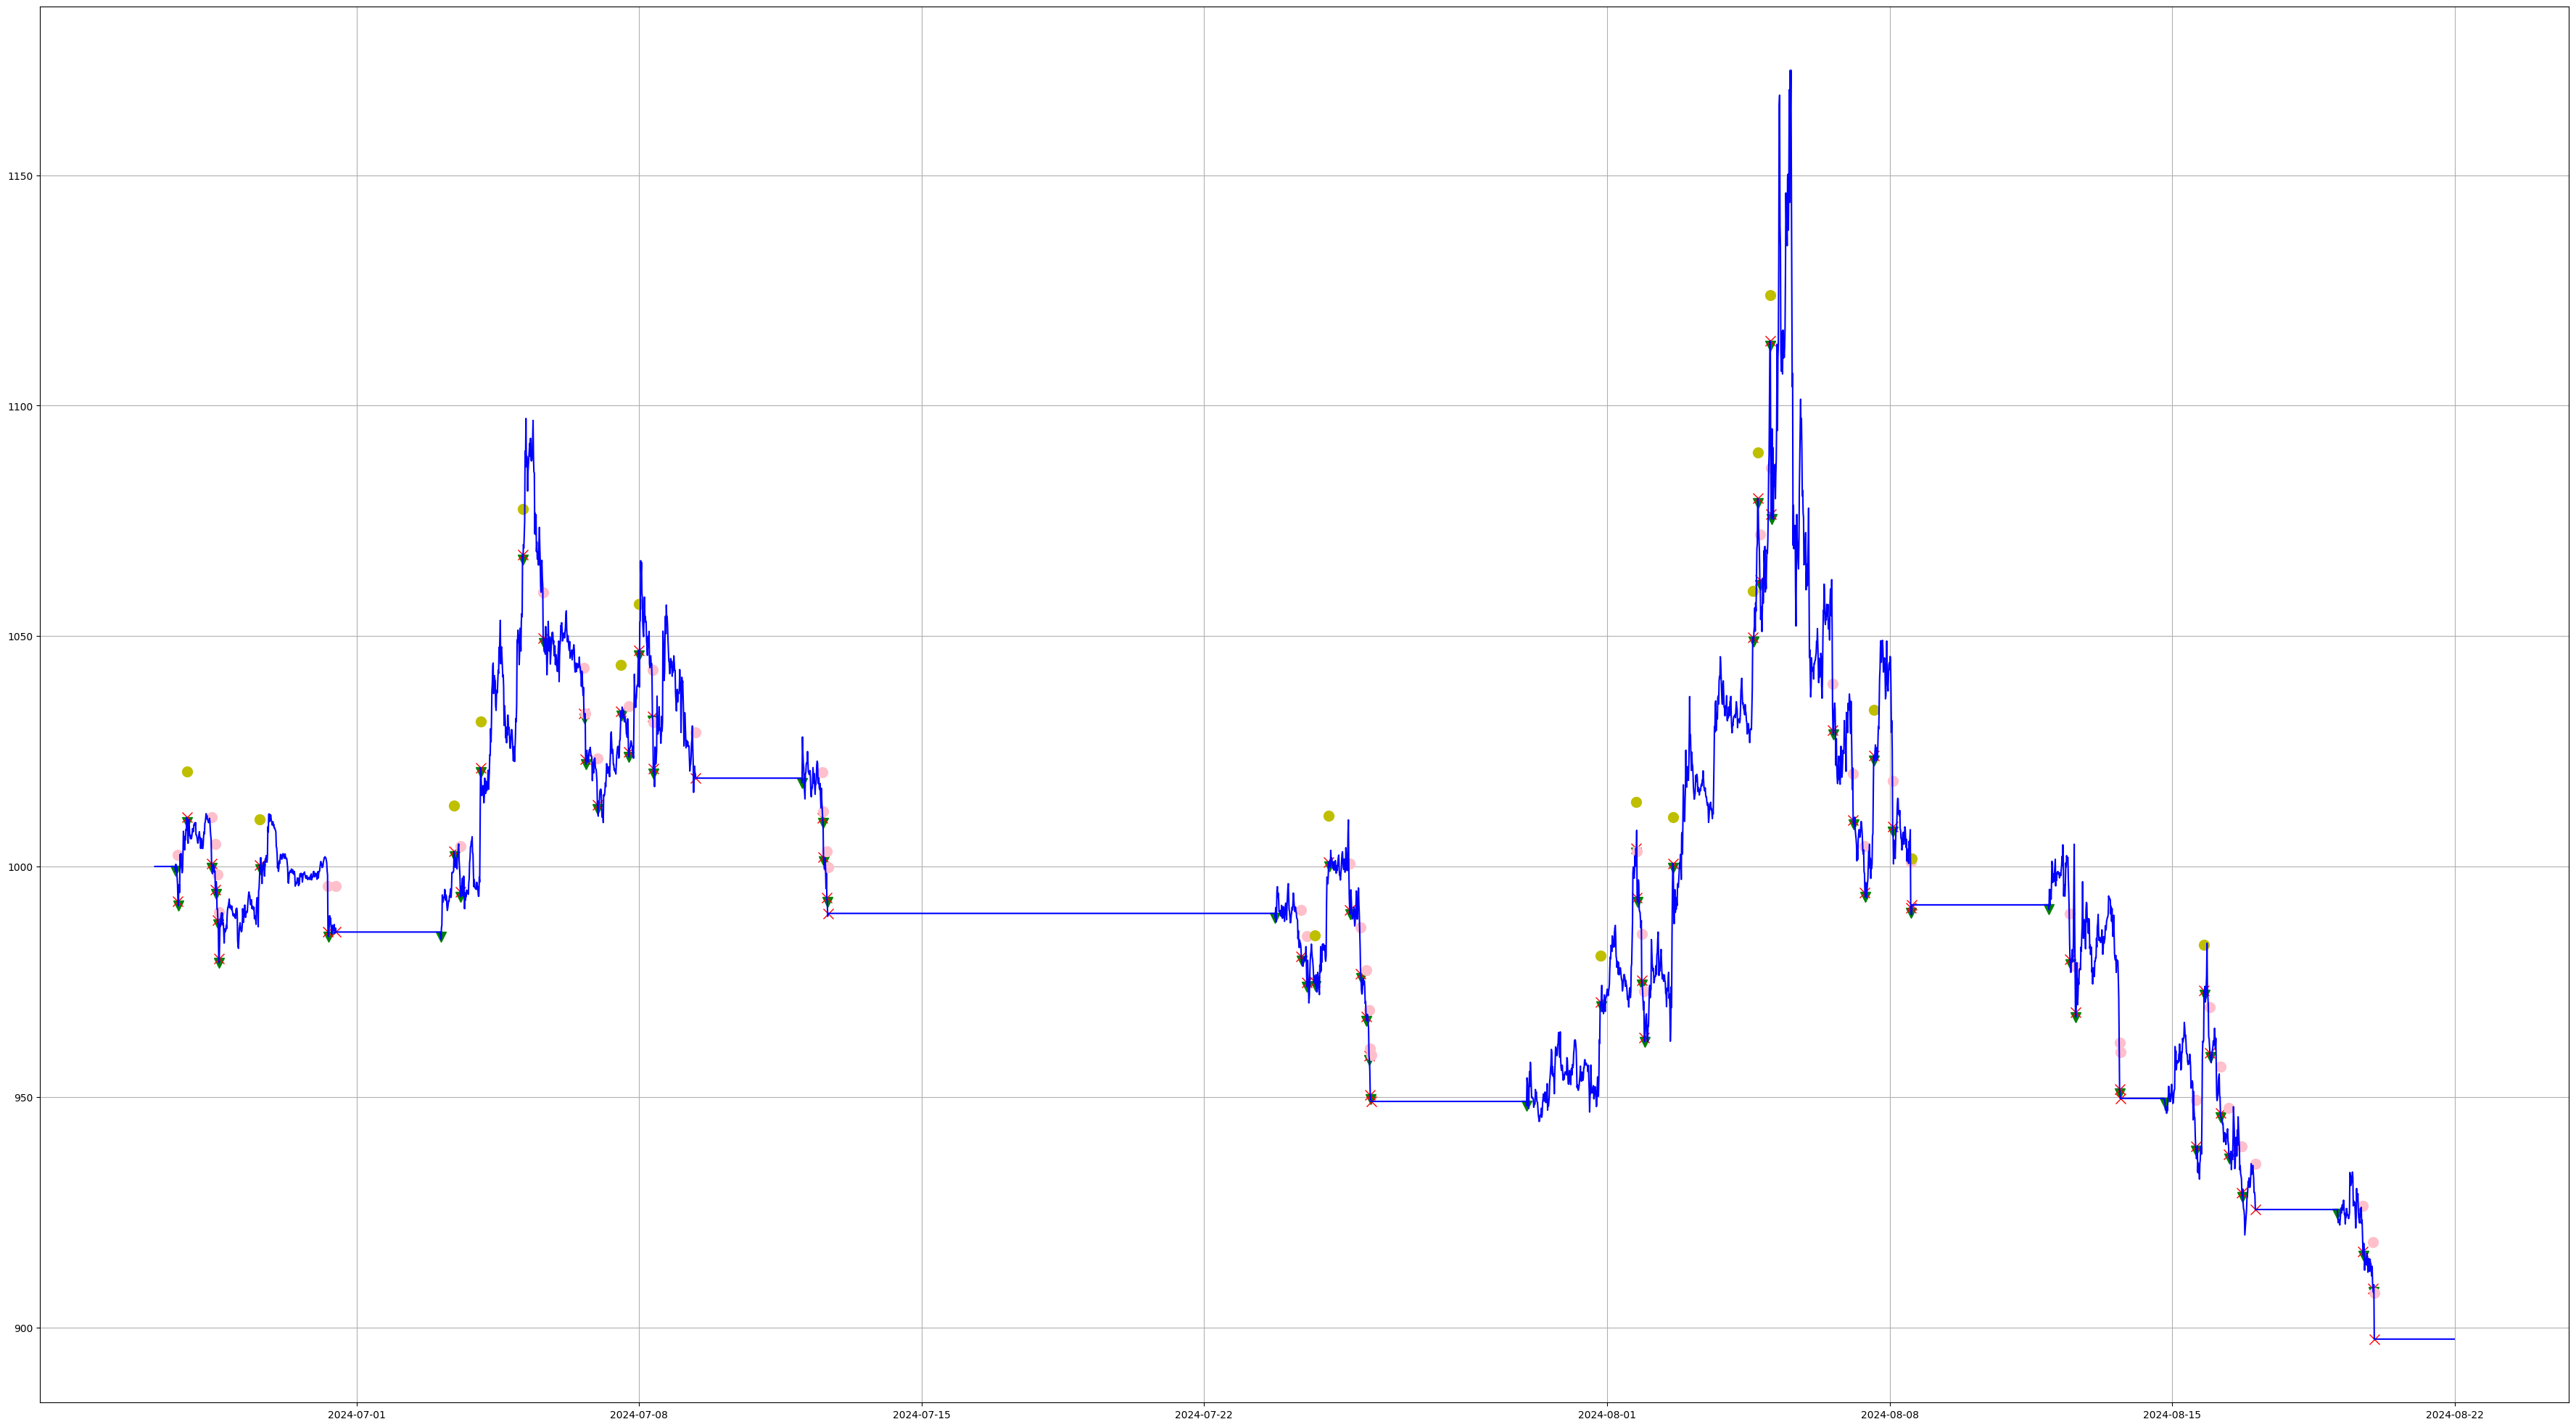

In [106]:
backtester = Backtester(emaStrategy, short_data, trade_commission=commission_percentage, amount_invested=amount_invested, leverage_ratio=leverage)
backtester.backtest()
backtester.plot_backtest()

In [107]:
backtester.get_metrics()

Final value:  897.4462153969406
P&L:  -102.5537846030594
Returns %:  -10.25537846030594
Number of trades:  69
Loss trades %:  73.91304347826087
Profit trades %:  26.08695652173913
Annual Sharpe ratio:  -1.017058015477106
Max profit %:  17.27891494268865
Max loss %:  -10.25537846030594


/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Final value: ', self.data['Cumulative Strategy Returns'][-1])
/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('P&L: ', (self.data['Cumulative Strategy Returns'][-1] - (self.leverage_ratio*self.amount_invested)))
/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys